In [35]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES
from pyts.classification import TimeSeriesForest

In [36]:
dataset_reference = pd.read_csv('../../datasets/sp_500_stocks/sp500_stocks.csv')
dataset_finviz = pd.read_csv('finviz_dataset.csv')
dataset_yahoo = pd.read_csv('yahoo_dataset.csv')

In [37]:
dataset_reference = dataset_reference.dropna()
dataset_reference = dataset_reference.sort_values("Date")
dataset_finviz = dataset_finviz.dropna()
dataset_finviz = dataset_finviz.sort_values("Date")
dataset_yahoo = dataset_yahoo.dropna()
dataset_yahoo = dataset_yahoo.sort_values("Date")

In [43]:
valores_unicos = dataset_reference["Symbol"].unique()
dataset_finviz = dataset_finviz[dataset_finviz["Ticker"].isin(valores_unicos)]
dataset_yahoo = dataset_yahoo[dataset_yahoo["Ticker"].isin(valores_unicos)]

In [44]:
from dateutil import parser

# Diccionario para traducir meses en español a inglés
MESES_ESP = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr", "may": "May", "jun": "Jun",
    "jul": "Jul", "ago": "Aug", "sep": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

# def corregir_fecha(fecha_str):
#     partes = fecha_str.split()
#     if len(partes) == 3:  # Asegurar que tiene día, mes y año
#         dia, mes, anio = partes
#         mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
#         fecha_corregida = f"{dia} {mes} {anio}"
#         return parser.parse(fecha_corregida, dayfirst=True).toordinal()
#     return None  # Retorna None si no es válida
def corregir_fecha(fecha_str):
    try:
        partes = fecha_str.split()
        if len(partes) == 3:  # Asegurar que tiene día, mes y año
            dia, mes, anio = partes
            mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
            fecha_corregida = f"{dia} {mes} {anio}"
            fecha_dt = parser.parse(fecha_corregida, dayfirst=True)  # Convertir a datetime
            return fecha_dt.strftime("%Y-%m-%d")  # Devolver en formato legible
    except Exception as e:
        print(f"Error con la fecha: {fecha_str} - {e}")
        return None  # Retorna None si hay un error

def actualizar_fecha(df, columna):
    df[columna] = df[columna].apply(lambda x: corregir_fecha(x) if pd.notna(x) else None)
    return df

dataset_yahoo = actualizar_fecha(dataset_yahoo, "Date")
dataset_yahoo

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
2285919,1970-04-01,ED,6.94,6.97,6.88,6.94,0.24,40400
2285664,1971-04-01,ED,6.72,6.75,6.69,6.75,0.25,96000
75122,1974-04-01,WMT,0.01,0.01,0.01,0.01,0.01,-
2248401,1974-04-01,DD,9.47,9.51,9.39,9.51,1.46,233336
3034422,1974-04-01,MKC,0.00,0.52,0.50,0.50,0.23,153600
...,...,...,...,...,...,...,...,...
558092,2024-09-09,UBER,70.95,71.19,69.63,69.80,69.80,8804600
1568945,2024-09-09,SRE,82.33,83.01,82.05,82.94,81.02,2231100
2235682,2024-09-09,DD,79.60,80.79,79.46,79.56,78.80,2999700
1768355,2024-09-09,ODFL,185.98,190.99,185.77,189.78,189.25,1445200


In [45]:
dataset_finviz["Date"] = pd.to_datetime(dataset_finviz["Date"], unit="s")

In [ ]:
def calculateFields(dataset):
    if 'Date' not in dataset:
        dataset['Date'] = dataset['date']
        dataset = dataset.drop(columns=["date"])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj Close'])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj_close'])
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High"])
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    if 'Symbol' in dataset:
        dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    else:
        dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
        dataset = dataset.drop(columns=['Ticker'])

    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago", "Symbol"]
fieldsPrice = ["average_price"]

In [47]:
dataset_reference = calculateFields(dataset_reference)
dataset_finviz = calculateFields(dataset_finviz)
dataset_yahoo = calculateFields(dataset_yahoo)

In [49]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [50]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(blockDf['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = blockDf[blockDf['Date'] < train_max_day].shape[0]
    testSamples = len(blockDf.index) - trainSamples

    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test, blockDf

In [51]:
def getTestSet(dataset0, blockDf0, daysRange):
    min_date = pd.to_datetime(blockDf0['Date'].max())
    max_date = min_date + pd.DateOffset(days=daysRange)
    filtered_df = dataset0[(dataset0['Date'] >= min_date) & (dataset0['Date'] <= max_date)]
    aux = filtered_df.copy()
    aux = aux.drop("Date", axis=1)
    X_test = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test = aux.copy()

    return X_test, Y_test

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

testRanges = [30, 90, 180, 365, 730, 1825]

def getRmse(dataset01, blockDf01, rfModel, testRangesIdx):
    X_test0, Y_test0 = getTestSet(dataset01, blockDf01, testRanges[testRangesIdx])
    y_pred = rfModel.predict(X_test0)
    rmse01 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse01

def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=10, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
    return rmse0

def testTfAndGetRmse(dataset0, daysOfBlocks0, daysOfTraining0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=10, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    return rmse0

def testTfAndGetRmse2(dataset0, daysOfBlocks0, daysOfTraining0, block_size0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=10, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    rmseList0 = [rmse0]
    for i in [0, 1, 2]:
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=10, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[i])
        rfts.fit(X_train0, Y_train0)
        rmse1 = dict()
        rmse1[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
        rmse1[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
        rmse1[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
        rmse1[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
        rmse1[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
        rmse1[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
        rmseList0.append(rmse1)
    return rmseList0

def getGraphData(presitionDataArray, bRfp, bs):
    all_arr = [bRfp]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in bs:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(presitionDataArray[blockSize][r])

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

def convertListOfDictToDictOfList(dictList0):
    newDict = dict()
    for dict0 in dictList0:
        for key in dict0:
            if key not in newDict:
                newDict[key] = []
            newDict[key].append(dict0[key])
    return newDict

def runTestsAndGetResults(dataset, DaysRange, DaysTrainRange, blockSizes):

    daysOfBlocks = DaysRange
    daysOfTraining = DaysTrainRange
    for i in range(len(blockSizes)):
        blockSizes[i] = int(blockSizes[i])

    basicRFPrecision = []
    for i in range(50):
        rmse = testTfAndGetRmse(dataset, DaysRange, DaysTrainRange)
        basicRFPrecision.append(rmse)
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)

    precisionNonOverlapping = dict()
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
            precisionNonOverlapping[block_size].append(rmse0)
    
    precisionMovingBlock = dict()
    for block_size in blockSizes:
        precisionMovingBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
            precisionMovingBlock[block_size].append(rmse0)
    
    precisionCircularBlock = dict()
    for block_size in blockSizes:
        precisionCircularBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
            precisionCircularBlock[block_size].append(rmse0)
    
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size])
        precisionMovingBlock[block_size] = convertListOfDictToDictOfList(precisionMovingBlock[block_size])
        precisionCircularBlock[block_size] = convertListOfDictToDictOfList(precisionCircularBlock[block_size])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

In [53]:
def runTestsAndGetResults2(dataset, DaysRange, DaysTrainRange, blockSizes):

    basicRFPrecision = []
    precisionNonOverlapping = dict()
    precisionMovingBlock = dict()
    precisionCircularBlock = dict()
    block_size = blockSizes[0]
    precisionNonOverlapping[block_size] = []
    precisionMovingBlock[block_size] = []
    precisionCircularBlock[block_size] = []
    for i in range(50):
        rmseList = testTfAndGetRmse2(dataset, DaysRange, DaysTrainRange, block_size)
        basicRFPrecision.append(rmseList[0])
        precisionNonOverlapping[block_size].append(rmseList[1])
        precisionMovingBlock[block_size].append(rmseList[2])
        precisionCircularBlock[block_size].append(rmseList[3])
    
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)
        
    for block_size0 in blockSizes:
        precisionNonOverlapping[block_size0] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size0])
        precisionMovingBlock[block_size0] = convertListOfDictToDictOfList(precisionMovingBlock[block_size0])
        precisionCircularBlock[block_size0] = convertListOfDictToDictOfList(precisionCircularBlock[block_size0])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

In [54]:
def getLinesGraphData(rfReference):
    ticks0 = []
    rfReferenceMeans = []
    for key in rfReference:
        ticks0.append(str(key))
        rfReferenceMeans.append(sum(rfReference[key]) / len(rfReference[key]))
    rfReferenceMeans
    return rfReferenceMeans, ticks0

def showGraph(FrRMSE_Ref, FrRMSE_Fin, FrRMSE_Yah, NoRMSE_Ref, NoRMSE_Fin, NoRMSE_Yah, algorithmName, TrainDays, blockSizes):
    all_arr1, ticksNames = getLinesGraphData(FrRMSE_Ref)
    all_arr2, ticksNames = getLinesGraphData(FrRMSE_Fin)
    all_arr3, ticksNames = getLinesGraphData(FrRMSE_Yah)
    all_arr4, ticksNames = getLinesGraphData(NoRMSE_Ref)
    all_arr5, ticksNames = getLinesGraphData(NoRMSE_Fin)
    all_arr6, ticksNames = getLinesGraphData(NoRMSE_Yah)

    plt.figure()

    bp1 = plt.plot(all_arr1, color='blue', label="RF - Referencia")
    bp2 = plt.plot(all_arr2, color='red', label="RF - Finviz")
    bp3 = plt.plot(all_arr3, color='yellow', label="RF - Yahoo")
    bp4 = plt.plot(all_arr4, color='green', label=f"{algorithmName} - Referencia")
    bp5 = plt.plot(all_arr5, color='cyan', label=f"{algorithmName} - Finviz")
    bp6 = plt.plot(all_arr6, color='purple', label=f"{algorithmName} - Yahoo")
    #bp3.colo
    # set_box_color(bp3, '#f03b20')
    # set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    # set_box_color(bp1, '#2C7BB6')
    # set_box_color(bp2, '#fdc086')

    plt.legend()

    plt.xticks(range(0, len(ticksNames)), ticksNames)
    plt.tight_layout()
    plt.title(f"Comparación entre algoritmos ({algorithmName})")
    plt.xlabel("Dias del conjunto de pruebas")
    plt.ylabel("RMSE")

In [55]:
def runTestAndCompareOneSigleBlockSize(TrainDays, bSize):
    bs = [bSize]
    FrRMSE_Ref, NoRMSE_Ref, BmRMSE_Ref, CbRMSE_Ref = runTestsAndGetResults2(dataset_reference, TrainDays + max(testRanges), TrainDays, bs)
    FrRMSE_Fin, NoRMSE_Fin, BmRMSE_Fin, CbRMSE_Fin = runTestsAndGetResults2(dataset_finviz, TrainDays + max(testRanges), TrainDays, bs)
    FrRMSE_Yah, NoRMSE_Yah, BmRMSE_Yah, CbRMSE_Yah = runTestsAndGetResults2(dataset_yahoo, TrainDays + max(testRanges), TrainDays, bs)
    showGraph(FrRMSE_Ref, FrRMSE_Fin, FrRMSE_Yah, NoRMSE_Ref[bSize], NoRMSE_Fin[bSize], NoRMSE_Yah[bSize], "Non-Overlaping", TrainDays, bs)
    showGraph(FrRMSE_Ref, FrRMSE_Fin, FrRMSE_Yah, BmRMSE_Ref[bSize], BmRMSE_Fin[bSize], BmRMSE_Yah[bSize], "Moving Block", TrainDays, bs)
    showGraph(FrRMSE_Ref, FrRMSE_Fin, FrRMSE_Yah, CbRMSE_Ref[bSize], CbRMSE_Fin[bSize], CbRMSE_Yah[bSize], "Circular Block", TrainDays, bs)
    

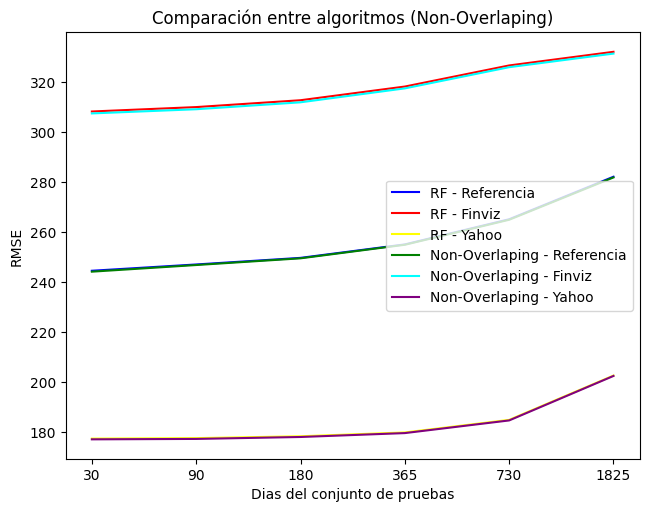

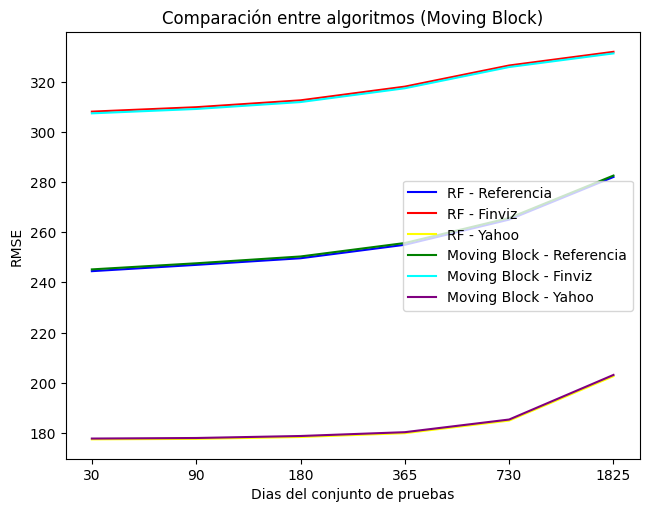

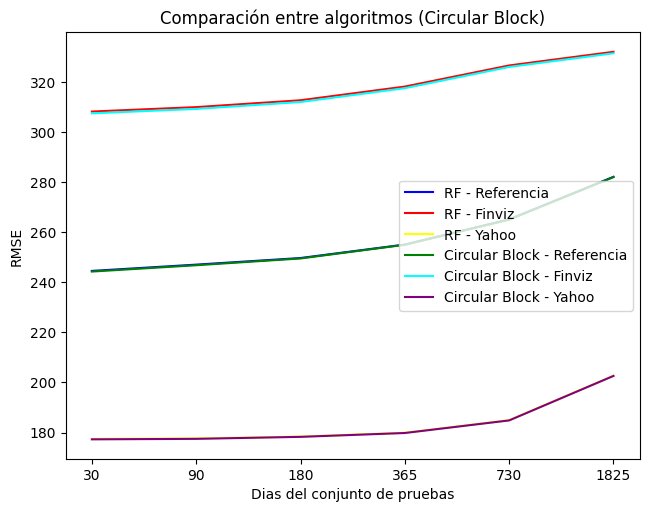

In [56]:
runTestAndCompareOneSigleBlockSize(365, 1500)

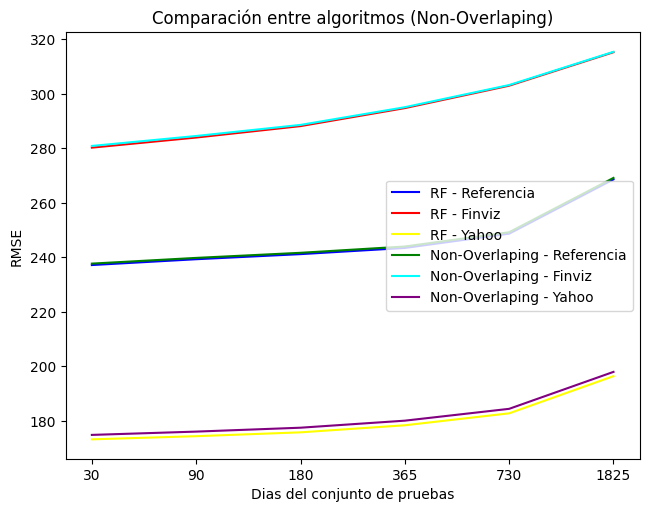

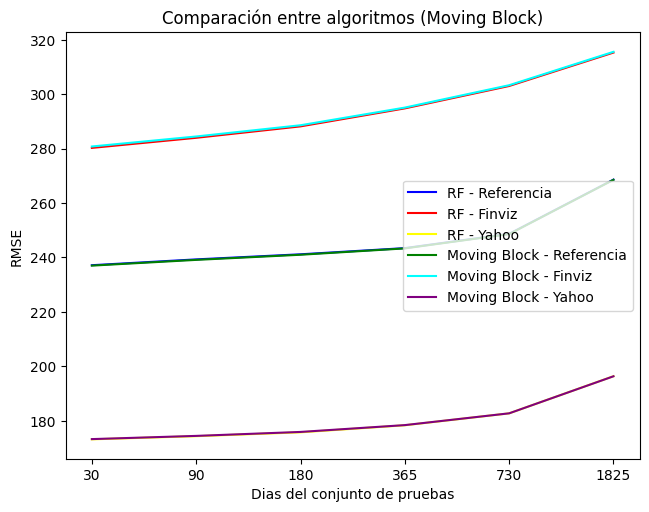

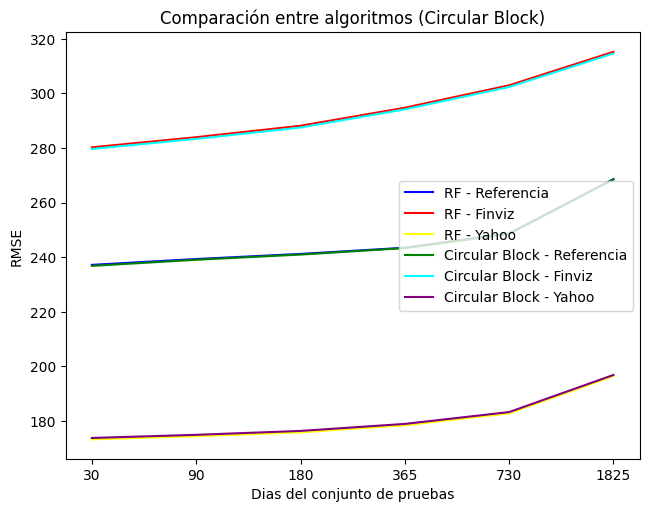

In [62]:
runTestAndCompareOneSigleBlockSize(30, 100)

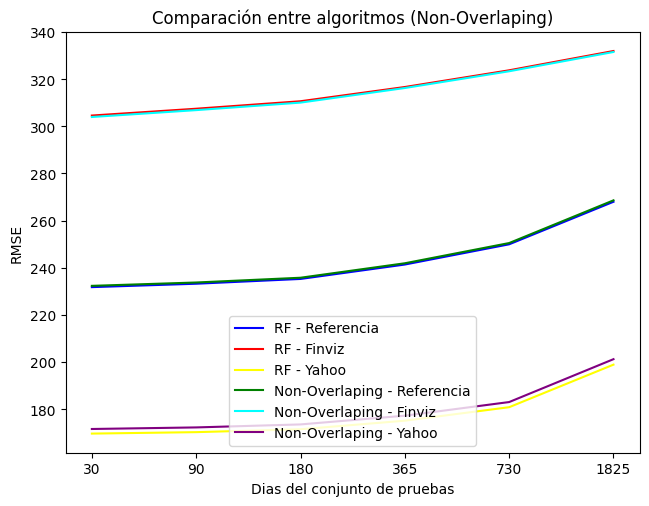

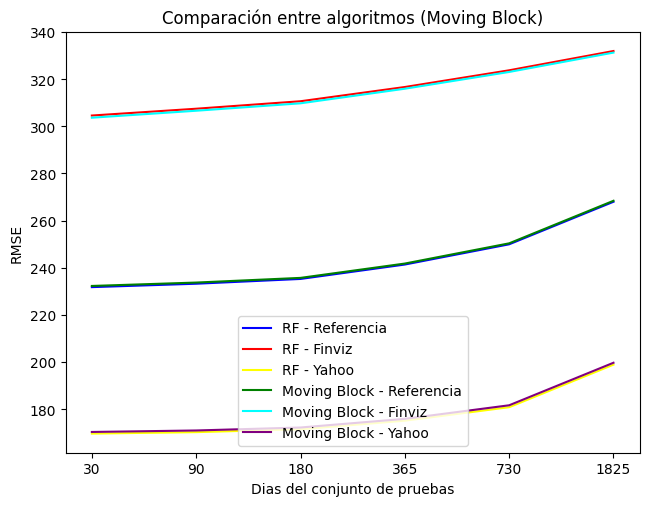

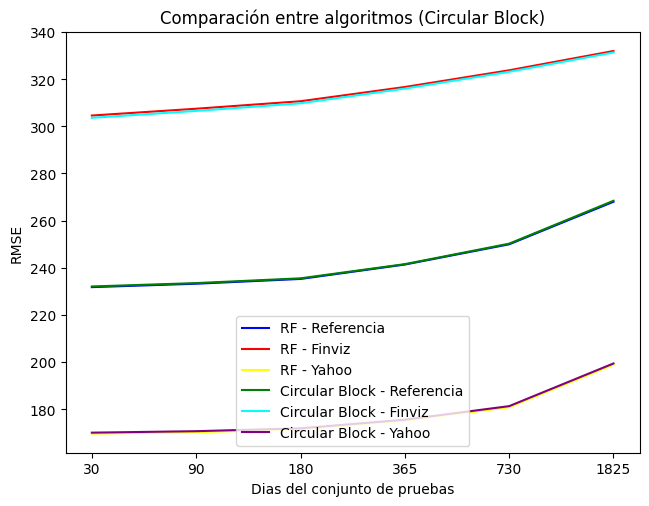

In [63]:
runTestAndCompareOneSigleBlockSize(90, 200)

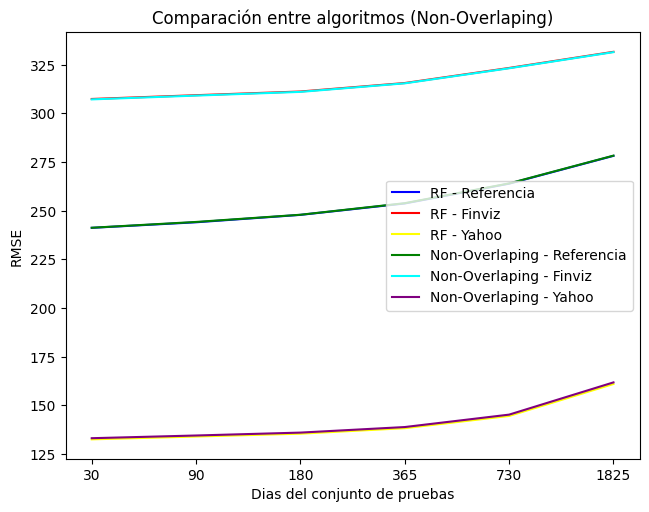

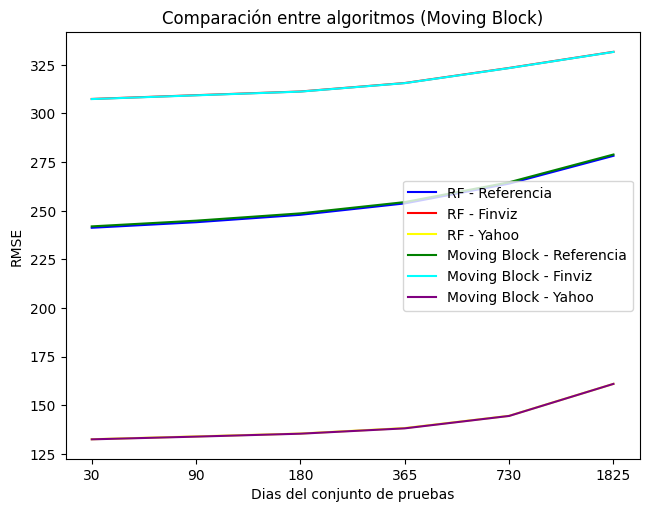

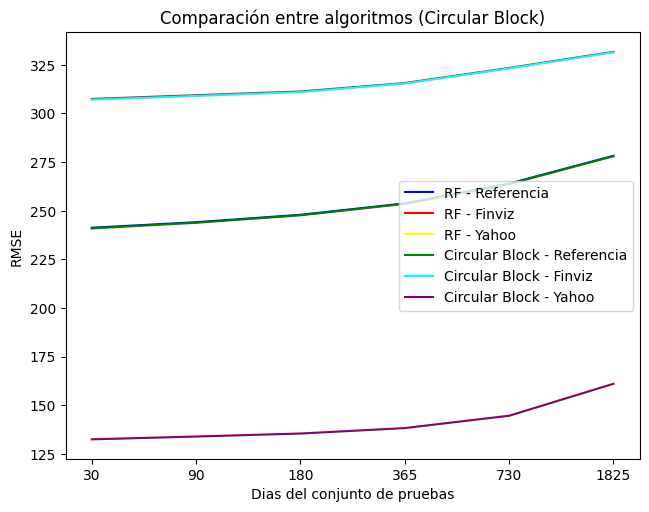

In [64]:
runTestAndCompareOneSigleBlockSize(180, 500)

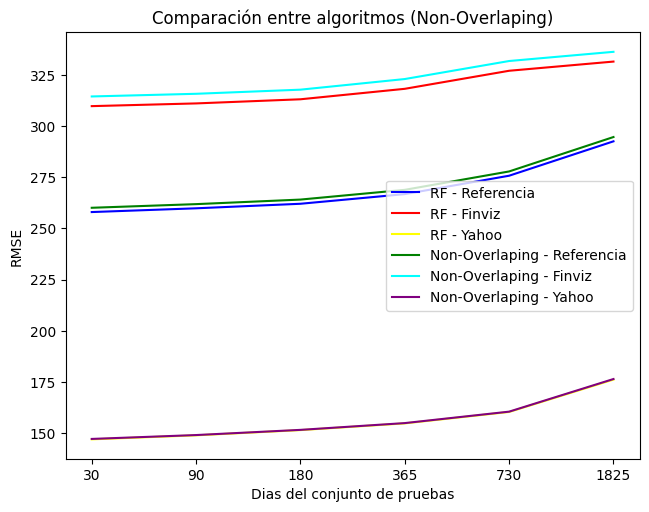

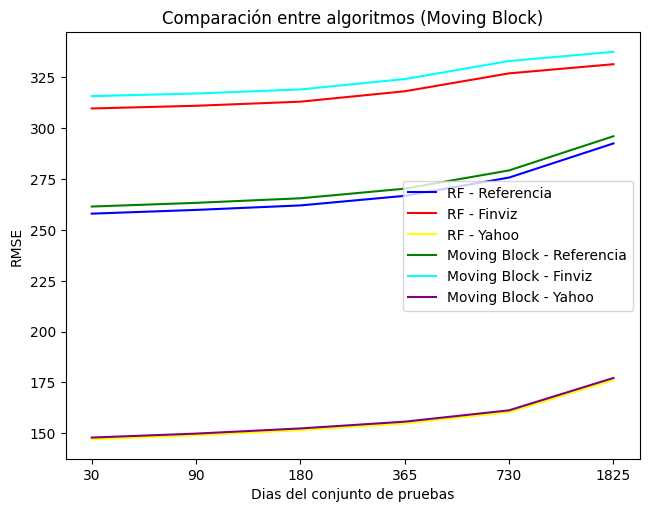

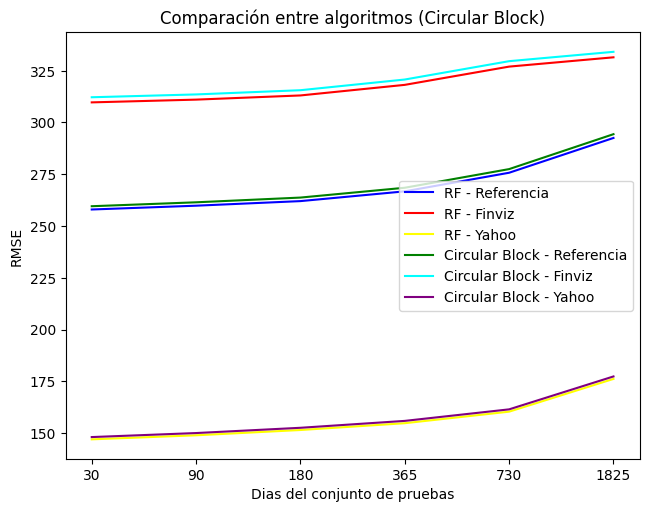

In [65]:
runTestAndCompareOneSigleBlockSize((365 * 2), 1500)

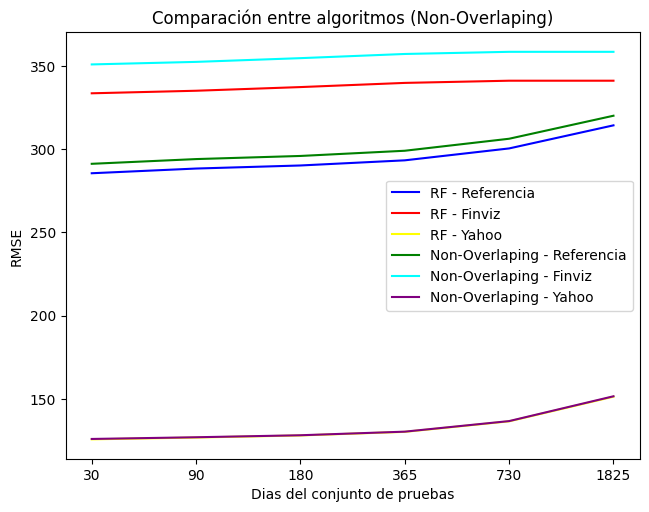

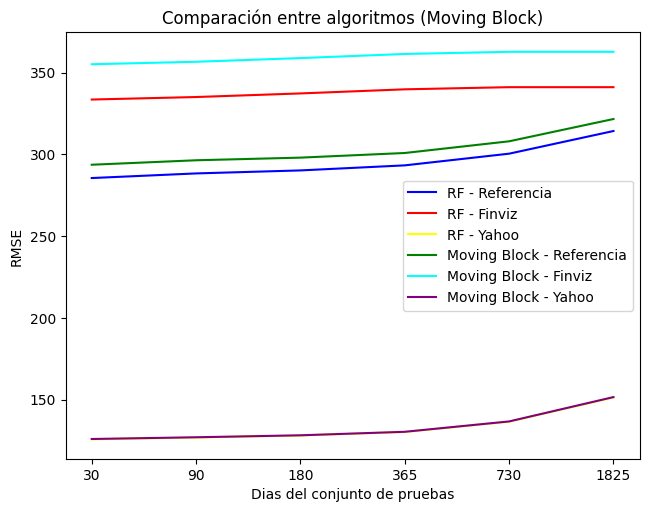

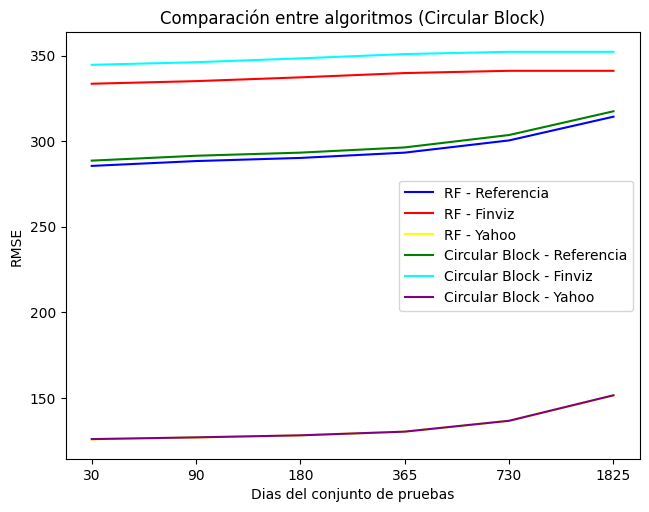

In [66]:
runTestAndCompareOneSigleBlockSize((365 * 3), 1500)

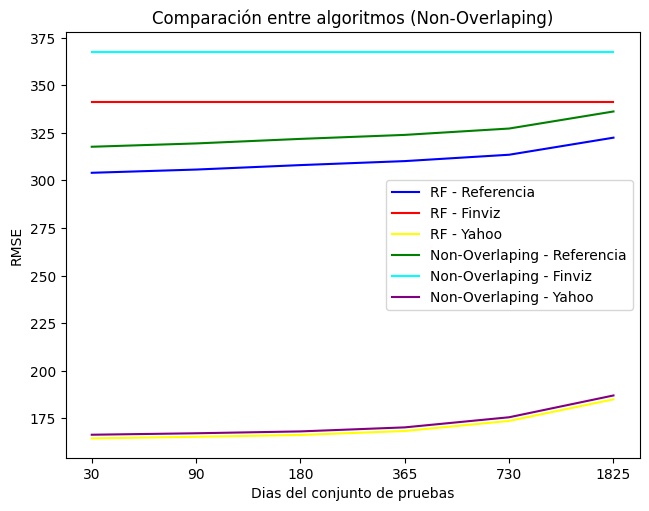

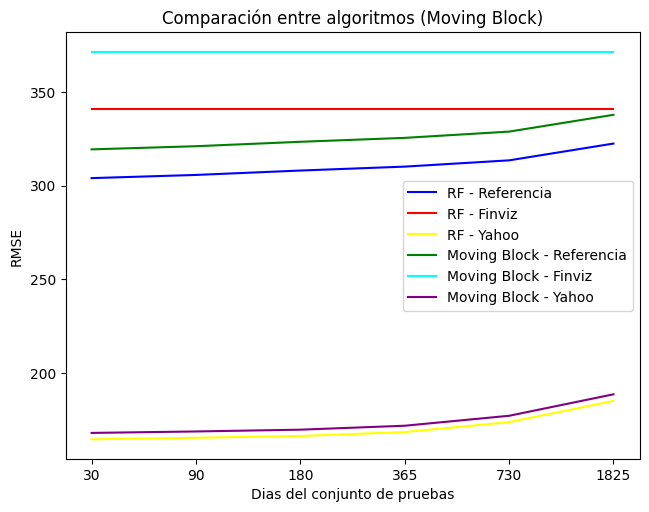

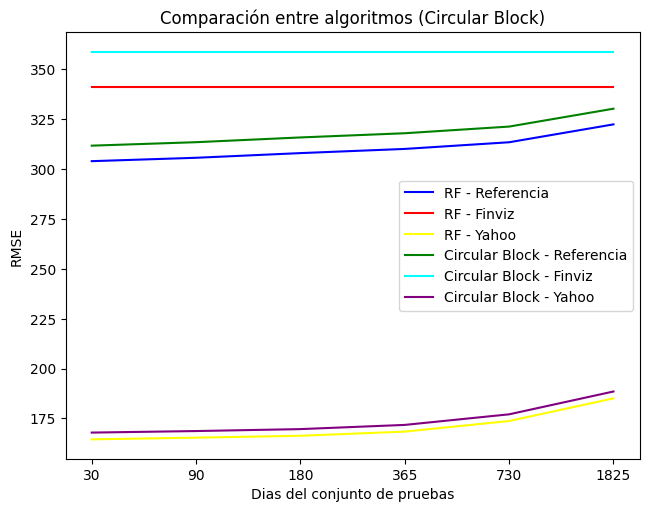

In [67]:
runTestAndCompareOneSigleBlockSize((365 * 4.5), 1500)

In [68]:
dataset_finviz

,Date,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,price_30_days_ago,price_180_days_ago,price_365_days_ago,Symbol
0,2014-12-15 14:00:00,735582,52.4000,0,12,2014,349,51,0,0,4,0,5,55.5500,28.0865,27.9425,0
1,2014-12-15 14:00:00,735582,20.1475,0,12,2014,349,51,0,0,4,0,5,100.7250,15.7020,76.0950,1
2,2014-12-15 14:00:00,735582,54.7185,0,12,2014,349,51,0,0,4,0,5,104.1550,50.6575,62.3500,2
3,2014-12-15 14:00:00,735582,49.5830,0,12,2014,349,51,0,0,4,0,5,15.3255,10.1500,61.4500,3
4,2014-12-15 14:00:00,735582,23.1535,0,12,2014,349,51,0,0,4,0,5,39.8235,227.2920,42.3050,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401891,2024-12-03 14:00:00,739223,602.7250,1,12,2024,338,49,0,0,4,0,3646,196.7800,20.4725,63.7100,129
401892,2024-12-03 14:00:00,739223,286.8550,1,12,2024,338,49,0,0,4,0,3646,196.4275,99.5200,119.3350,104
401893,2024-12-03 14:00:00,739223,407.2030,1,12,2024,338,49,0,0,4,0,3646,308.2250,50.4600,64.2950,50
401894,2024-12-03 14:00:00,739223,82.5470,1,12,2024,338,49,0,0,4,0,3646,262.6650,189.2475,43.0750,165
